# Import, Init

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4dzqemem because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  0
>>> train-test inited:  
 	X_train len -->  1994 y_train len -->  1994 
 	X_test len -->  1992 y_test len -->  1992 
 	NULLS in data -->  0


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY',
       'Next_day_Price'],
      dtype='object')

In [5]:
# nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                            inplace=True, errors='ignore')
# nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                             inplace=True, errors='ignore')

## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week
nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open', 'Next_day_Price'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [6]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


# Preparing data

#### Swapping (the trial issue)
[[to #Model-fit]](#Model-fit)

In [7]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_test = nn_manager_cut.X_train.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = nn_manager_cut.y_train.copy()
nn_manager_cut.y_train = tmp.copy()

print("X_train => ", nn_manager_cut.X_train.shape[0])
print("X_test => ", nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train =>  1992
X_test =>  1994
	train data period =>  2016-01-02 00:00:00 --> 2021-06-15 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2016-01-01 00:00:00


#### Keeping Left-off Samples Aside

In [8]:
left_off_days = 21
left_off_X = nn_manager_cut.X_train[-left_off_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-left_off_days]

left_off_y = nn_manager_cut.y_train[-left_off_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-left_off_days]

nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0]

(1971, 1994)

## Normalizing

In [9]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

(
    nn_manager_cut.X_test_normalized[:2], 
    nn_manager_cut.X_test_transformed
)

(array([[-0.82604885, -0.82352348, -0.33692929, -1.2892465 , -0.6648523 ,
         -2.99792455, -1.24649385, 13.09502262,  0.03948667, -2.22389752],
        [-0.82604885, -0.82352348, -0.33590187, -1.29460087, -0.66814668,
         -2.99746938, -1.24649156, 13.09502262,  0.03948667, -2.22389752]]),
 None)

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [10]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=1))

self.training_seq_params -->  {'seq_len': 1, 'n_features': 10}
self.X_train_shape -->  [1, 10]
self.X_test_shape -->  [1, 10]


True

In [11]:
nn_manager_cut.unroll_train_test_to_sequences()

True

In [12]:
nn_manager_cut.X_test_unrolled[0]

array([[-0.82604885, -0.82352348, -0.33692929, -1.2892465 , -0.6648523 ,
        -2.99792455, -1.24649385, 13.09502262,  0.03948667, -2.22389752]])

In [13]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[-0.82604885, -0.82352348, -0.33590187, -1.29460087, -0.66814668,
        -2.99746938, -1.24649156, 13.09502262,  0.03948667, -2.22389752]])

In [14]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(            Price
 Date             
 2010-07-18    0.1
 2010-07-19    0.1
 2010-07-20    0.1
 2010-07-21    0.1
 2010-07-22    0.1
 2010-07-23    0.1,
 array([[0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [15]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [16]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(1, 10)

In [17]:
# LSTM Architecture for hard periods train-test split

weights_init = GlorotNormal()

template_DNS = [

    Dense(150, 
          activation=LeakyReLU(alpha=0.3),
          input_shape=(nn_manager_cut.training_seq_params['seq_len'], 
                       nn_manager_cut.training_seq_params['n_features']),
          kernel_initializer=weights_init
         ),
    Dense(350, 
          activation=LeakyReLU(alpha=0.3),
          kernel_initializer=weights_init
         ),
    Dense(250, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(50, 
      activation=LeakyReLU(alpha=0.3),
      kernel_initializer=weights_init
     ),
    Dense(1)
]

In [18]:
nn_manager_cut.X_train_unrolled.shape

(1970, 1, 10)

### Compiling Model with the chosen Architecture

In [19]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=3e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_DNS, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 150)            1650      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 350)            52850     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 250)            87750     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 50)             12550     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              51        
Total params: 154,851
Trainable params: 154,851
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [20]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1970, 1, 10], [1993, 1, 10])

CPU times: user 1min 22s, sys: 12 s, total: 1min 34s
Wall time: 35.5 s


(0.0, 2000.0)

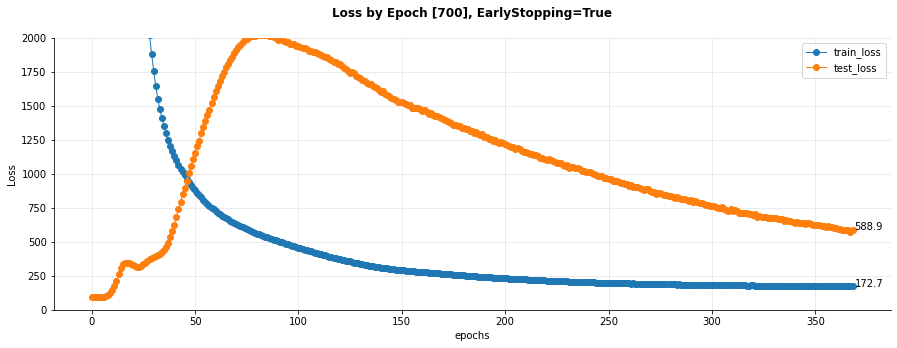

In [21]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue))

# Saving Model

In [22]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_DNSe_working')

In [23]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [24]:
left_off_X[:3]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,
2021-05-26,40750.0,37847.0,153800.0,2.222384e+06,77.846658,1.300155,644838441.0,756.25,-9210.0,233414.0
2021-05-27,40322.2,37190.8,122930.0,1.982669e+06,66.114770,1.262394,645069798.0,718.75,-30870.0,231357.0
2021-05-28,38844.1,34772.4,199580.0,2.897052e+06,69.535068,1.343872,645284958.0,831.25,76650.0,215160.0


In [25]:
left_off_X_unrolled, left_off_y_unrolled = nn_manager_cut.unroll_train_test_to_sequences(
    X=nn_manager_cut.scaler.transform(left_off_X), 
    y =left_off_y.values
)

left_off_X_unrolled[-1:], left_off_X_unrolled.shape[0]

>>> Method called with outer X and y. Returning X, y unrolled...


(array([[[ 4.1267506 ,  4.06027625, -0.00717094, -0.10317781,
          -0.26791862,  0.85144883,  1.12340124, -0.54751131,
           0.48094768, -0.84886695]]]),
 20)

In [26]:
left_off_date_index = left_off_y.index[nn_manager_cut.training_seq_params['seq_len']:]
left_off_date_index

DatetimeIndex(['2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
               '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [27]:
left_off_pred = [nn_manager_cut.model_predict(seq.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0][0]
                 for seq in left_off_X_unrolled]
left_off_pred[:2]

[39381.08, 38832.87]

<AxesSubplot:xlabel='Date'>

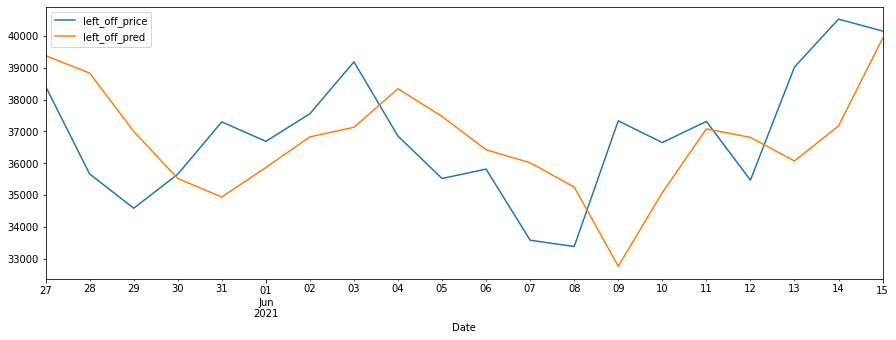

In [28]:
fig, ax = plt.subplots(1, figsize=(15,5))

pd.DataFrame(data=left_off_y_unrolled, index=left_off_date_index, columns=["left_off_price"]).plot(ax=ax)
pd.DataFrame(data=left_off_pred, index=left_off_date_index, columns=["left_off_pred"]).plot(ax=ax)

>>>Calculating predictions... done.


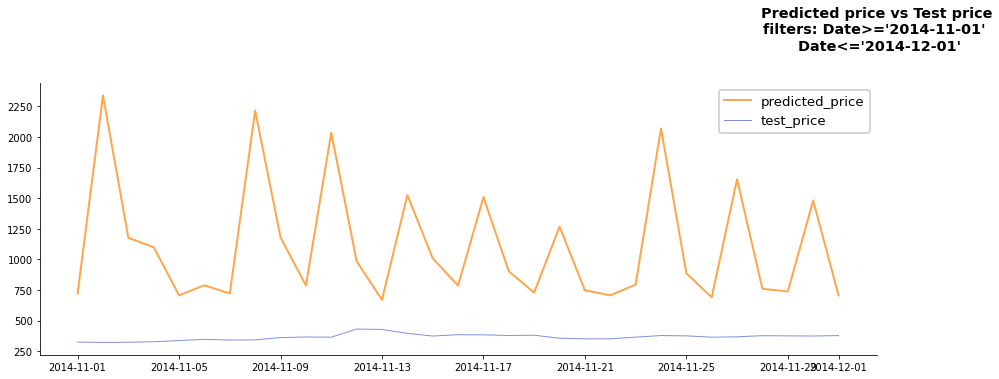

In [29]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-01'", "Date<='2014-12-01'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [30]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [31]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [32]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [33]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [34]:
# nn_manager_cut.y_test_unrolled[:3]

In [35]:
# nn_manager_cut.y_pred[:3]

In [36]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]